In [4]:
import tensorflow
import pandas as pd
import numpy as np
import random
import cv2
import os
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import plot_model
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/EuroSAT.zip' -d my_data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: my_data/2750/SeaLake/SeaLake_1313.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_263.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_967.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_515.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_1465.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_1817.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_2902.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_2570.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_1004.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_174.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_2111.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_2388.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_1948.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_838.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_2738.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_1999.jpg  
  inflating: my_data/2750/SeaLake/SeaLake_2359.jpg  
  inflating: my_data/2750/SeaLake/Se

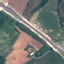

In [10]:
img = image.load_img('my_data/2750/Highway/Highway_1.jpg')
img

In [ ]:
img.size

(64, 64)

In [16]:
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_data = generator.flow_from_directory('EuroSAT/', subset='training', target_size=(64, 64), batch_size=21600)
# val_data = generator.flow_from_directory('EuroSAT/', subset='validation', target_size=(64, 64), batch_size=5400)

# train_data = generator.flow_from_directory('my_data/2750/', subset='training', target_size=(64, 64), batch_size=21600)
# val_data = generator.flow_from_directory('my_data/2750/', subset='validation', target_size=(64, 64), batch_size=5400)

train_data = generator.flow_from_directory('my_data/2750/', subset='training', target_size=(64, 64))
val_data = generator.flow_from_directory('my_data/2750/', subset='validation', target_size=(64, 64))

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
classes = pd.DataFrame([val_data.class_indices]).transpose()
classes.rename(columns={0:'class_No'}, inplace=True)
classes

class_No
AnnualCrop                   0
Forest                       1
HerbaceousVegetation         2
Highway                      3
Industrial                   4
Pasture                      5
PermanentCrop                6
Residential                  7
River                        8
SeaLake                      9

In [28]:
xtrain, ytrain = next(train_data)
xval, yval = next(val_data)
print('xtrain shape:', xtrain.shape)
print('xtest shape: ', xval.shape)
print('ytrain shape:', ytrain.shape)
print('ytest shape: ', yval.shape)

xtrain shape: (32, 64, 64, 3)
xtest shape:  (32, 64, 64, 3)
ytrain shape: (32, 10)
ytest shape:  (32, 10)


In [ ]:
np.array(np.unique(ytrain_classes, return_counts=True)).T

array([['AnnualCrop', '2400'],
       ['Forest', '2400'],
       ['HerbaceousVegetation', '2400'],
       ['Highway', '2000'],
       ['Industrial', '2000'],
       ['Pasture', '1600'],
       ['PermanentCrop', '2000'],
       ['Residential', '2400'],
       ['River', '2000'],
       ['SeaLake', '2400']], dtype='<U21')

In [ ]:
ytrain_classes = []
for i in range(len(ytrain)):
  dict_keys=val_data.class_indices.keys()
  cl_dict=dict(zip(dict_keys, ytrain[i]))
  classkey = [k for k,v in cl_dict.items() if v==max(cl_dict.values())]
  ytrain_classes.append(classkey[0])
  
  yval_classes = []
for i in range(len(yval)):
  dict_keys=val_data.class_indices.keys()
  cl_dict=dict(zip(dict_keys, yval[i]))
  classkey = [k for k,v in cl_dict.items() if v==max(cl_dict.values())]
  yval_classes.append(classkey[0])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

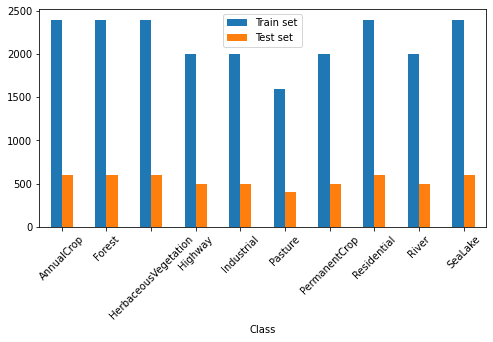

In [ ]:
df_split=pd.DataFrame(np.array(np.unique(ytrain_classes, return_counts=True)).T)
df_split.rename(columns={0:'Class', 1:'Train set'}, inplace=True)
df_val=pd.DataFrame(np.array(np.unique(yval_classes, return_counts=True)).T)
df_split['Test set'] = df_val[1].astype(int)
df_split['Train set'] = df_split['Train set'].astype(int)
df_split['Class'] = df_split['Class'].values.astype(str)
df_split.set_index('Class', inplace=True)
df_split.plot.bar(figsize=(8,4))
plt.xticks(rotation=45)

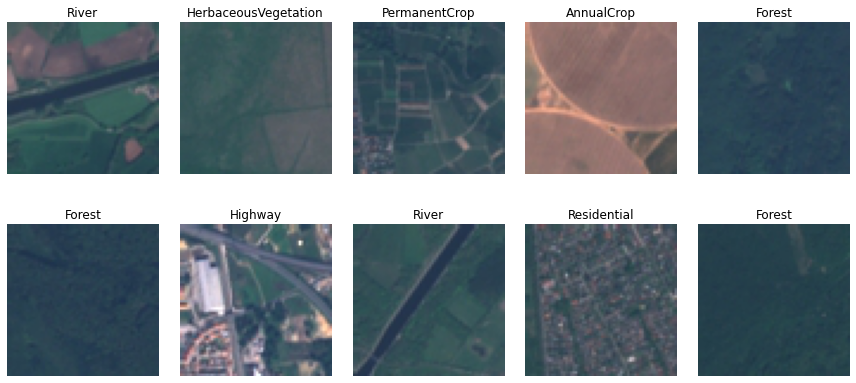

In [ ]:
ytrain_classes = []
for i in range(len(ytrain)):
  dict_keys=val_data.class_indices.keys()
  cl_dict=dict(zip(dict_keys, ytrain[i]))
  classkey = [k for k,v in cl_dict.items() if v==max(cl_dict.values())]
  ytrain_classes.append(classkey[0])

fig,ax=plt.subplots(2,5, figsize =(12,6))
for i in range(2):
  for j in range (5):
    l = random.randint(0,len(ytrain_classes))
    ax[i,j].imshow(xtrain[l])
    ax[i,j].set_title(ytrain_classes[l])
    ax[i,j].axis('off')
plt.tight_layout()

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=((64, 64, 3))),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)), 

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),    
    
    Conv2D(filters=128, kernel_size=(3,3), padding='same'),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding='same'),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    # Final Layer, 10 neurons = 10 classes
    Dense(10), Activation('softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

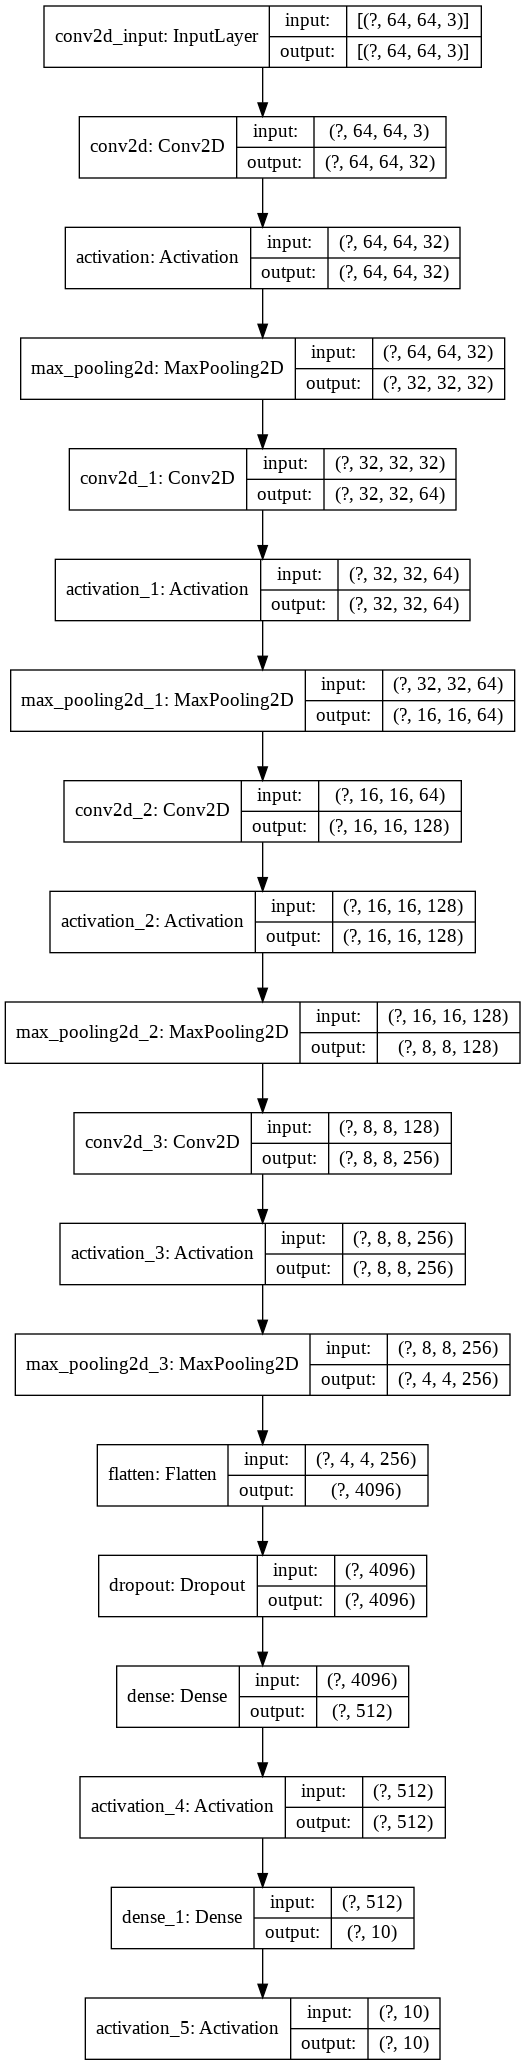

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer="Adam")

In [ ]:
# history = model.fit_generator(train_data, validation_data=val_data, epochs=1)
history = model.fit(x=xtrain, y=ytrain, batch_size=100, epochs=20, validation_data=(xval, yval))

Epoch 1/20
216/216 [==============================] - 259s 1s/step - loss: 0.1912 - accuracy: 0.9325 - val_loss: 0.2659 - val_accuracy: 0.9091
Epoch 2/20
216/216 [==============================] - 259s 1s/step - loss: 0.1883 - accuracy: 0.9330 - val_loss: 0.3271 - val_accuracy: 0.8839
Epoch 3/20
216/216 [==============================] - 257s 1s/step - loss: 0.1619 - accuracy: 0.9426 - val_loss: 0.2711 - val_accuracy: 0.9104
Epoch 4/20
216/216 [==============================] - 257s 1s/step - loss: 0.1543 - accuracy: 0.9467 - val_loss: 0.2419 - val_accuracy: 0.9206
Epoch 5/20
216/216 [==============================] - 259s 1s/step - loss: 0.1477 - accuracy: 0.9488 - val_loss: 0.3195 - val_accuracy: 0.8911
Epoch 6/20
216/216 [==============================] - 262s 1s/step - loss: 0.1366 - accuracy: 0.9520 - val_loss: 0.2931 - val_accuracy: 0.9074
Epoch 7/20
216/216 [==============================] - 262s 1s/step - loss: 0.1122 - accuracy: 0.9596 - val_loss: 0.2845 - val_accuracy: 0.9193

In [ ]:
# # save model:
# # model to JSON
# with open("model.json", "w") as json_file:
#     json_file.write(model.to_json())

# # weights to HDF5
# model.save("model.h5")

In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("model.h5")

In [ ]:
score = model.evaluate(xval, yval, verbose=2)

169/169 - 17s - loss: 0.2942 - accuracy: 0.9174


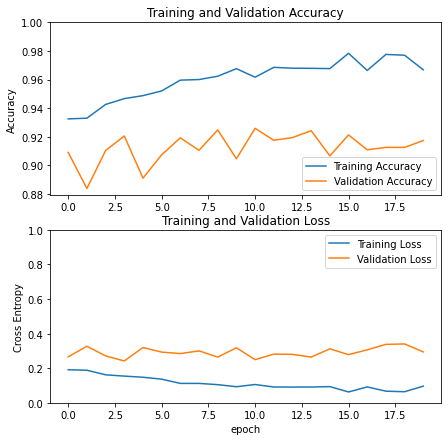

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [412]:
model_01 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=((64, 64, 3))),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)), 
    (Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu")),
    (MaxPool2D(pool_size=(2,2),strides=(2,2))),
    (Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")),
    (Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")),
    (MaxPool2D(pool_size=(2,2),strides=(2,2))),
    (Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")),
    (Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")),
    (MaxPool2D(pool_size=(2,2),strides=(2,2))),
    (Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")),
    (Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")),
    (MaxPool2D(pool_size=(2,2),strides=(2,2))),

    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    # Final Layer, 10 neurons = 10 classes
    Dense(10), Activation('softmax')])

model_01.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)       

In [25]:
model_01.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer="Adam")

In [26]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
history = model_01.fit_generator(train_data, validation_data=val_data, epochs=10, callbacks=[callback])

Epoch 1/10
675/675 [==============================] - 241s 356ms/step - loss: 1.5805 - accuracy: 0.3656 - val_loss: 1.2112 - val_accuracy: 0.5580
Epoch 2/10
675/675 [==============================] - 242s 358ms/step - loss: 0.9647 - accuracy: 0.6488 - val_loss: 0.8073 - val_accuracy: 0.7154
Epoch 3/10
675/675 [==============================] - 241s 358ms/step - loss: 0.7518 - accuracy: 0.7287 - val_loss: 0.7117 - val_accuracy: 0.7504
Epoch 4/10
675/675 [==============================] - 241s 357ms/step - loss: 0.6414 - accuracy: 0.7741 - val_loss: 0.6223 - val_accuracy: 0.7856
Epoch 5/10
675/675 [==============================] - 242s 359ms/step - loss: 0.5729 - accuracy: 0.8006 - val_loss: 0.5421 - val_accuracy: 0.8111
Epoch 6/10
675/675 [==============================] - 242s 359ms/step - loss: 0.5205 - accuracy: 0.8193 - val_loss: 0.6280 - val_accuracy: 0.7776
Epoch 7/10
675/675 [==============================] - 242s 358ms/step - loss: 0.4661 - accuracy: 0.8372 - val_loss: 0.4686 -

In [29]:
score = model_01.evaluate(xval, yval, verbose=2)

1/1 - 0s - loss: 0.3415 - accuracy: 0.9062


**Confusion Matrix**

In [ ]:
ypred = np.argmax(model.predict(xval), axis=-1)
ypred

array([7, 2, 1, ..., 6, 4, 6])

In [ ]:
y_val=np.argmax(yval,axis=1)
y_val

array([7, 2, 1, ..., 2, 4, 6])

In [ ]:
class_dict=val_data.class_indices
class_dict = {value:key for key, value in class_dict.items()}
class_dict.values()

dict_values(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'])

In [ ]:
confusion_matrix(y_val, ypred)

array([[528,   3,   5,  14,   0,  10,   8,   1,  24,   7],
       [  0, 570,   7,   0,   0,  19,   0,   0,   3,   1],
       [ 14,   3, 521,  17,   3,   8,  23,   6,   3,   2],
       [  3,   0,   7, 451,  21,   0,   3,   4,  11,   0],
       [  0,   0,   3,   6, 488,   0,   0,   2,   1,   0],
       [  2,   3,   7,  21,   0, 352,   6,   0,   9,   0],
       [ 25,   0,  87,  45,   2,   5, 334,   0,   2,   0],
       [  0,   0,   7,   5,  28,   0,   1, 559,   0,   0],
       [  4,   2,   7,  64,   0,   7,   1,   0, 414,   1],
       [  2,   4,   1,   1,   0,   3,   0,   0,   4, 585]])

In [ ]:
# plt.figure(figsize=[10.0, 7.5])
# sns.heatmap(confusion_matrix(y_val, ypred), annot=True, fmt="d", linewidths=.5)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

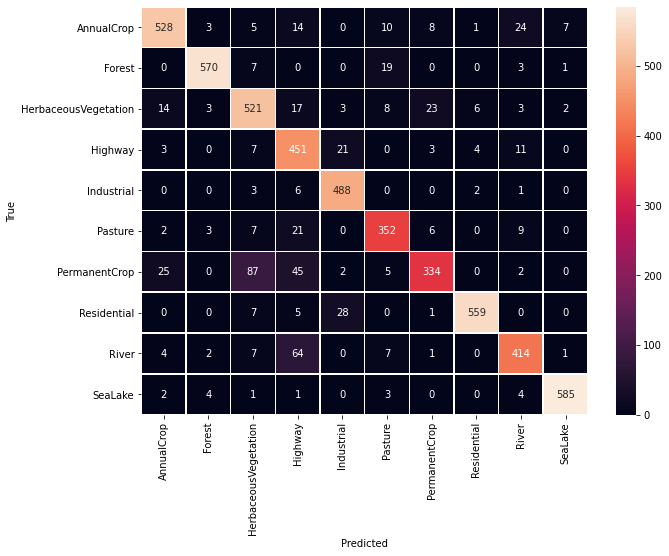

In [ ]:
plt.figure(figsize=[10.0, 7.5])
sns.heatmap(confusion_matrix(y_val, ypred), annot=True, fmt="d", linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(0.5,10), ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], rotation='vertical')
plt.yticks(np.arange(0.5,10), ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], rotation='horizontal')
plt.show()

**Transfer Learning**

In [ ]:
# by selecting include_top=False - get the pre-trained model without its final classification layer
# base_model.trainable = False - freezes the weights and biases of the pre-trained model so that only manually defined final layers are trained

**ResNet50**

In [ ]:
base_model = tensorflow.keras.applications.ResNet50(input_shape=(64,64,3), include_top=False)
base_model.trainable = False

model2 = tensorflow.keras.Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    Dense(10), Activation('softmax')])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_15 (Activation)   (None, 10)               

In [ ]:
#plot_model(base_model, show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer="Adam")

In [ ]:
history = model2.fit(x=xtrain, y=ytrain, batch_size=100, epochs=10, validation_data=(xval, yval))

Epoch 1/10
216/216 [==============================] - 347s 2s/step - loss: 2.0317 - accuracy: 0.2559 - val_loss: 1.7321 - val_accuracy: 0.3856
Epoch 2/10
216/216 [==============================] - 343s 2s/step - loss: 1.8396 - accuracy: 0.3132 - val_loss: 1.6536 - val_accuracy: 0.4526
Epoch 3/10
216/216 [==============================] - 340s 2s/step - loss: 1.7692 - accuracy: 0.3406 - val_loss: 1.5930 - val_accuracy: 0.4761
Epoch 4/10
216/216 [==============================] - 343s 2s/step - loss: 1.7422 - accuracy: 0.3525 - val_loss: 1.5660 - val_accuracy: 0.4467
Epoch 5/10
216/216 [==============================] - 341s 2s/step - loss: 1.7206 - accuracy: 0.3580 - val_loss: 1.5574 - val_accuracy: 0.4824
Epoch 6/10
216/216 [==============================] - 343s 2s/step - loss: 1.6901 - accuracy: 0.3678 - val_loss: 1.5162 - val_accuracy: 0.4274
Epoch 7/10
216/216 [==============================] - 342s 2s/step - loss: 1.6955 - accuracy: 0.3649 - val_loss: 1.5191 - val_accuracy: 0.4287

In [ ]:
score = model2.evaluate(xval, yval, verbose=2)

169/169 - 74s - loss: 1.4860 - accuracy: 0.4980


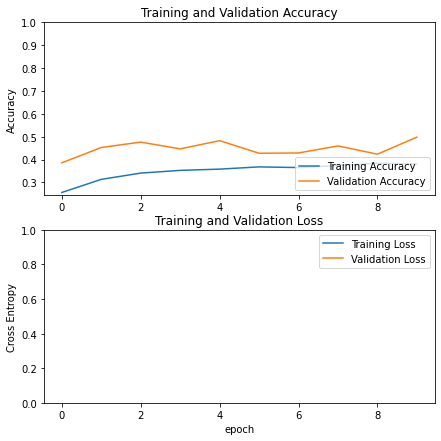

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**MobileNetV2**

In [ ]:
# input_shape: Optional shape tuple, only to be specified if include_top is False 
# (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) 
# or (3, 224, 224) (with channels_first data format). 
# It should have exactly 3 inputs channels, and width and height should be no smaller than 32. 
# E.g. (200, 200, 3) would be one valid value. Default to None. input_shape will be ignored if the input_tensor is provided.

base_model = tensorflow.keras.applications.MobileNetV2(input_shape=(64,64,3), include_top=False)
base_model.trainable = False

model3 = tensorflow.keras.Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    Dense(10), Activation('softmax')])

model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
flatten_8 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5120)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               2621952   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_17 (Activation)   (None, 10)               

In [ ]:
model3.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer="Adam")

In [ ]:
history = model3.fit(x=xtrain, y=ytrain, batch_size=100, epochs=10, validation_data=(xval, yval))

Epoch 1/10
216/216 [==============================] - 84s 388ms/step - loss: 0.8814 - accuracy: 0.7408 - val_loss: 0.5524 - val_accuracy: 0.8028
Epoch 2/10
216/216 [==============================] - 88s 406ms/step - loss: 0.5010 - accuracy: 0.8262 - val_loss: 0.4879 - val_accuracy: 0.8354
Epoch 3/10
216/216 [==============================] - 85s 393ms/step - loss: 0.4222 - accuracy: 0.8519 - val_loss: 0.4803 - val_accuracy: 0.8369
Epoch 4/10
216/216 [==============================] - 86s 398ms/step - loss: 0.3786 - accuracy: 0.8662 - val_loss: 0.4665 - val_accuracy: 0.8398
Epoch 5/10
216/216 [==============================] - 85s 394ms/step - loss: 0.3331 - accuracy: 0.8827 - val_loss: 0.4696 - val_accuracy: 0.8389
Epoch 6/10
216/216 [==============================] - 85s 394ms/step - loss: 0.3013 - accuracy: 0.8933 - val_loss: 0.4786 - val_accuracy: 0.8454
Epoch 7/10
216/216 [==============================] - 87s 403ms/step - loss: 0.2718 - accuracy: 0.9046 - val_loss: 0.4933 - val_ac

In [ ]:
score = model3.evaluate(xval, yval, verbose=2)

169/169 - 18s - loss: 0.5232 - accuracy: 0.8474


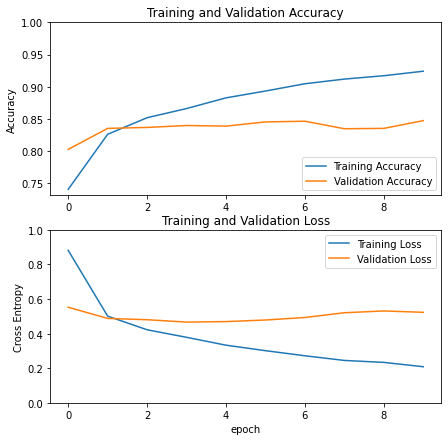

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**VGG16**

In [ ]:
base_model = tensorflow.keras.applications.VGG16(input_shape=(64,64,3), include_top=False)
base_model.trainable = False

model4 = tensorflow.keras.Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    Dense(10), Activation('softmax')])

model4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
activation_24 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_25 (Activation)   (None, 10)              

In [ ]:
model4.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer="Adam")

In [ ]:
history = model4.fit(x=xtrain, y=ytrain, batch_size=100, epochs=10, validation_data=(xval, yval))

Epoch 1/10
216/216 [==============================] - 1100s 5s/step - loss: 0.8510 - accuracy: 0.6950 - val_loss: 0.5645 - val_accuracy: 0.8052
Epoch 2/10
216/216 [==============================] - 1101s 5s/step - loss: 0.6350 - accuracy: 0.7759 - val_loss: 0.5187 - val_accuracy: 0.8120
Epoch 3/10
216/216 [==============================] - 1102s 5s/step - loss: 0.5881 - accuracy: 0.7923 - val_loss: 0.4728 - val_accuracy: 0.8309
Epoch 4/10
216/216 [==============================] - 1097s 5s/step - loss: 0.5550 - accuracy: 0.8015 - val_loss: 0.4412 - val_accuracy: 0.8456
Epoch 5/10
216/216 [==============================] - 1102s 5s/step - loss: 0.5320 - accuracy: 0.8089 - val_loss: 0.4368 - val_accuracy: 0.8472
Epoch 6/10
216/216 [==============================] - 1103s 5s/step - loss: 0.5104 - accuracy: 0.8173 - val_loss: 0.4230 - val_accuracy: 0.8469
Epoch 7/10
216/216 [==============================] - 1102s 5s/step - loss: 0.5007 - accuracy: 0.8205 - val_loss: 0.3992 - val_accuracy:

In [ ]:
score = model4.evaluate(xval, yval, verbose=2)

169/169 - 223s - loss: 0.4214 - accuracy: 0.8528


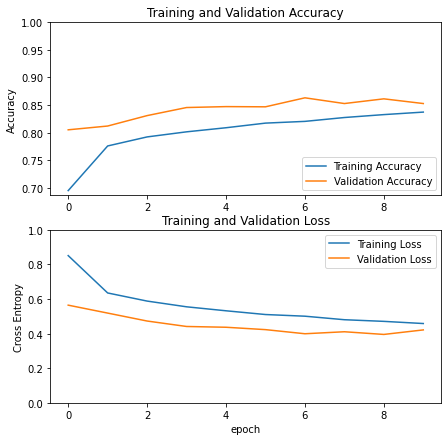

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine-Tuning: MobileNetV2**

In [ ]:
# In transfer learning models only a few layers on top of a base model were trainde. 
# The weights of the pre-trained network were not updated during training.
# One way to increase performance further is to train (or "fine-tune") the weights of the top layers of the pre-trained model to associate them specifically with the dataset.
# The first few layers learn very simple and generic features that generalize to almost all types of images. 
# As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. 
# The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.


base_model = tensorflow.keras.applications.MobileNetV2(input_shape=(64,64,3), include_top=False)
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model5 = tensorflow.keras.Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    Dense(10), Activation('softmax')])

model5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
flatten_13 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5120)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               2621952   
_________________________________________________________________
activation_26 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_27 (Activation)   (None, 10)              

In [ ]:
# Compile the model using a lower learning rate (otherwise the magnitude of the gradient updates will be too large)
base_learning_rate = 0.0001
model5.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tensorflow.keras.optimizers.Adam(lr=base_learning_rate/10))

In [ ]:
history = model5.fit(x=xtrain, y=ytrain, batch_size=100, epochs=10, validation_data=(xval, yval))

Epoch 1/10
216/216 [==============================] - 199s 922ms/step - loss: 2.3635 - accuracy: 0.2824 - val_loss: 2.6291 - val_accuracy: 0.1944
Epoch 2/10
216/216 [==============================] - 198s 916ms/step - loss: 1.4178 - accuracy: 0.5391 - val_loss: 1.8410 - val_accuracy: 0.3624
Epoch 3/10
216/216 [==============================] - 201s 930ms/step - loss: 1.0851 - accuracy: 0.6467 - val_loss: 1.5799 - val_accuracy: 0.4328
Epoch 4/10
216/216 [==============================] - 198s 916ms/step - loss: 0.9107 - accuracy: 0.7006 - val_loss: 1.2958 - val_accuracy: 0.5230
Epoch 5/10
216/216 [==============================] - 199s 921ms/step - loss: 0.8015 - accuracy: 0.7365 - val_loss: 1.1996 - val_accuracy: 0.5954
Epoch 6/10
216/216 [==============================] - 201s 933ms/step - loss: 0.7160 - accuracy: 0.7667 - val_loss: 1.0503 - val_accuracy: 0.6537
Epoch 7/10
216/216 [==============================] - 199s 919ms/step - loss: 0.6353 - accuracy: 0.7905 - val_loss: 0.8229 -

In [ ]:
score = model5.evaluate(xval, yval, verbose=2)

169/169 - 17s - loss: 0.4929 - accuracy: 0.8420


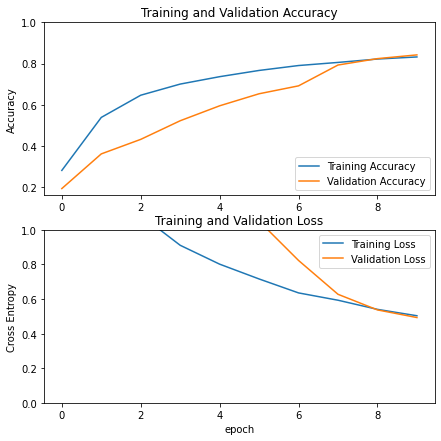

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Image Augmentation**

In [ ]:
# Applying data augmentation to improve results and avoid overfitting
gen = ImageDataGenerator(rotation_range=180, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         vertical_flip=True)

train_gen = gen.flow(xtrain, ytrain)
test_gen = gen.flow(xval, yval)

In [ ]:
# Training a model on an augmented dataset.
history = model5.fit_generator(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10
675/675 [==============================] - 249s 369ms/step - loss: 0.8622 - accuracy: 0.7291 - val_loss: 0.5760 - val_accuracy: 0.8085
Epoch 2/10
675/675 [==============================] - 249s 368ms/step - loss: 0.7707 - accuracy: 0.7483 - val_loss: 0.5362 - val_accuracy: 0.8267
Epoch 3/10
675/675 [==============================] - 243s 360ms/step - loss: 0.7032 - accuracy: 0.7685 - val_loss: 0.4885 - val_accuracy: 0.8330
Epoch 4/10
675/675 [==============================] - 248s 368ms/step - loss: 0.6709 - accuracy: 0.7775 - val_loss: 0.4890 - val_accuracy: 0.8335
Epoch 5/10
675/675 [==============================] - 249s 369ms/step - loss: 0.6442 - accuracy: 0.7848 - val_loss: 0.4714 - val_accuracy: 0.8476
Epoch 6/10
675/675 [==============================] - 248s 368ms/step - loss: 0.6249 - accuracy: 0.7911 - val_loss: 0.4426 - val_accuracy: 0.8509
Epoch 7/10
675/675 [==============================] - 247s 366ms/step - loss: 0.6063 - accuracy: 0.7964 - val_loss: 0.4413 -

In [ ]:
score = model5.evaluate(xval, yval, verbose=2)

169/169 - 17s - loss: 0.3492 - accuracy: 0.8870


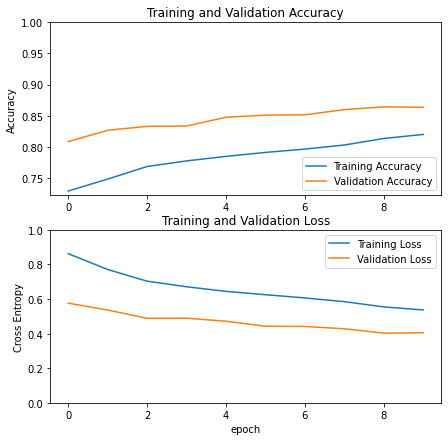

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine-Tuning: VGG16**

In [ ]:
base_model = tensorflow.keras.applications.VGG16(input_shape=(64,64,3), include_top=False)
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

58892288/58889256 [==============================] - 0s 0us/step
Number of layers in the base model:  19


In [ ]:
base_model.layers

In [ ]:
# Fine-tune from this layer onwards
#fine_tune_at = 8

fine_tune_at = 14

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
model6 = tensorflow.keras.Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512), Activation('relu'),
    Dense(10), Activation('softmax')])

model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0

In [ ]:
# Compile the model using a lower learning rate (otherwise the magnitude of the gradient updates will be too large)
base_learning_rate = 0.0001
model6.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tensorflow.keras.optimizers.Adam(lr=base_learning_rate/10))

In [ ]:
history = model6.fit(x=xtrain, y=ytrain, batch_size=100, epochs=10, validation_data=(xval, yval))

Epoch 1/10
216/216 [==============================] - 1310s 6s/step - loss: 0.2679 - accuracy: 0.9090 - val_loss: 0.2579 - val_accuracy: 0.9128
Epoch 2/10
216/216 [==============================] - 1304s 6s/step - loss: 0.2442 - accuracy: 0.9187 - val_loss: 0.2643 - val_accuracy: 0.9078
Epoch 3/10
216/216 [==============================] - 1303s 6s/step - loss: 0.2217 - accuracy: 0.9261 - val_loss: 0.2452 - val_accuracy: 0.9150
Epoch 4/10
216/216 [==============================] - 1307s 6s/step - loss: 0.2063 - accuracy: 0.9298 - val_loss: 0.2326 - val_accuracy: 0.9200
Epoch 5/10
216/216 [==============================] - 1307s 6s/step - loss: 0.1939 - accuracy: 0.9355 - val_loss: 0.2442 - val_accuracy: 0.9148
Epoch 6/10
216/216 [==============================] - 1303s 6s/step - loss: 0.1804 - accuracy: 0.9397 - val_loss: 0.2249 - val_accuracy: 0.9231
Epoch 7/10
216/216 [==============================] - 1308s 6s/step - loss: 0.1678 - accuracy: 0.9437 - val_loss: 0.2417 - val_accuracy:

In [ ]:
score = model6.evaluate(xval, yval, verbose=2)

169/169 - 199s - loss: 0.2257 - accuracy: 0.9250


In [ ]:
# save model:
# model to JSON
with open("model6.json", "w") as json_file:
    json_file.write(model6.to_json())

# weights to HDF5
model6.save("model6.h5")

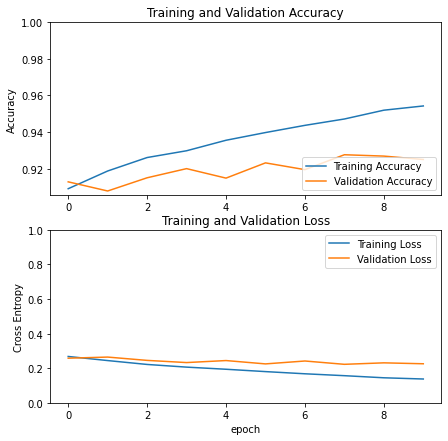

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Image Augmentation**

In [ ]:
# Applying data augmentation to improve results and avoid overfitting
gen = ImageDataGenerator(rotation_range=180, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         vertical_flip=True)

train_gen = gen.flow(xtrain, ytrain)
test_gen = gen.flow(xval, yval)

In [ ]:
# Training a model on an augmented dataset.
history = model6.fit_generator(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10
675/675 [==============================] - 1369s 2s/step - loss: 0.3390 - accuracy: 0.8842 - val_loss: 0.3385 - val_accuracy: 0.8874
Epoch 2/10
675/675 [==============================] - 1362s 2s/step - loss: 0.3174 - accuracy: 0.8932 - val_loss: 0.2951 - val_accuracy: 0.8967
Epoch 3/10
675/675 [==============================] - 1365s 2s/step - loss: 0.2934 - accuracy: 0.8980 - val_loss: 0.3059 - val_accuracy: 0.8933
Epoch 4/10
675/675 [==============================] - 1365s 2s/step - loss: 0.2856 - accuracy: 0.9031 - val_loss: 0.2780 - val_accuracy: 0.9022
Epoch 5/10
675/675 [==============================] - 1364s 2s/step - loss: 0.2734 - accuracy: 0.9041 - val_loss: 0.2487 - val_accuracy: 0.9154
Epoch 6/10
675/675 [==============================] - 1367s 2s/step - loss: 0.2663 - accuracy: 0.9075 - val_loss: 0.2584 - val_accuracy: 0.9124
Epoch 7/10
675/675 [==============================] - 1373s 2s/step - loss: 0.2608 - accuracy: 0.9106 - val_loss: 0.2623 - val_accuracy:

In [ ]:
score = model6.evaluate(xval, yval, verbose=2)

169/169 - 202s - loss: 0.2788 - accuracy: 0.9093


In [ ]:
# save model:
# model to JSON
with open("model6.json", "w") as json_file:
    json_file.write(model6.to_json())

# weights to HDF5
model6.save("model6.h5")

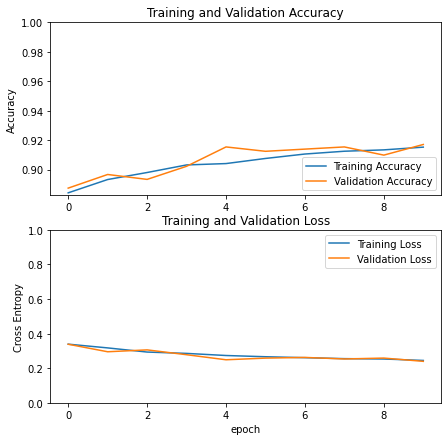

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Early stopping**

In [ ]:
# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.

callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

history = model6.fit_generator(train_gen, epochs=10, validation_data=test_gen, callbacks=[callback])


Epoch 1/10
675/675 [==============================] - 1514s 2s/step - loss: 0.3302 - accuracy: 0.8870 - val_loss: 0.2854 - val_accuracy: 0.9017
Epoch 2/10
675/675 [==============================] - 1518s 2s/step - loss: 0.3096 - accuracy: 0.8952 - val_loss: 0.2818 - val_accuracy: 0.9017
Epoch 3/10
675/675 [==============================] - 1508s 2s/step - loss: 0.2991 - accuracy: 0.8988 - val_loss: 0.2709 - val_accuracy: 0.9063
Epoch 4/10
675/675 [==============================] - 1505s 2s/step - loss: 0.2862 - accuracy: 0.9002 - val_loss: 0.2703 - val_accuracy: 0.9091
Epoch 5/10
675/675 [==============================] - 1506s 2s/step - loss: 0.2773 - accuracy: 0.9049 - val_loss: 0.2487 - val_accuracy: 0.9128
Epoch 6/10
675/675 [==============================] - 1508s 2s/step - loss: 0.2679 - accuracy: 0.9066 - val_loss: 0.2420 - val_accuracy: 0.9180
Epoch 7/10
675/675 [==============================] - 1512s 2s/step - loss: 0.2579 - accuracy: 0.9106 - val_loss: 0.2398 - val_accuracy:

In [ ]:
score = model6.evaluate(xval, yval, verbose=2)

169/169 - 220s - loss: 0.2661 - accuracy: 0.9143


In [ ]:
# save model:
# model to JSON
with open("model6.json", "w") as json_file:
    json_file.write(model6.to_json())

# weights to HDF5
model6.save("model6.h5")

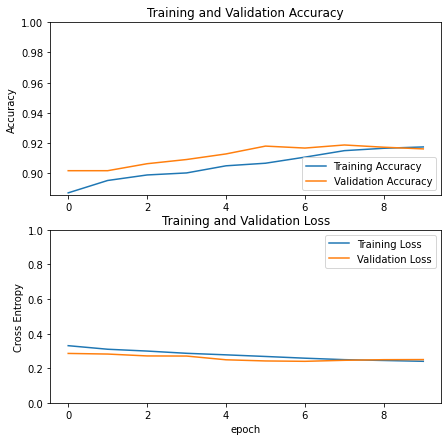

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Loading saved model and weights**

In [ ]:
json_file = open('/content/drive/My Drive/model6.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into the model
loaded_model.load_weights("/content/drive/My Drive/model6.h5")

loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
score = loaded_model.evaluate(xval, yval, verbose=2)

169/169 - 223s - loss: 0.0630 - accuracy: 0.8850


**Confusion Matrix**

In [ ]:
ypred = np.argmax(loaded_model.predict(xval), axis=-1)
y_val=np.argmax(yval,axis=1)
confusion_matrix(y_val, ypred)

array([[527,   2,   2,  14,   0,  13,  34,   0,   2,   6],
       [  0, 585,   1,   1,   0,   5,   0,   4,   2,   2],
       [  0,  32, 445,   7,   2,   9,  41,  62,   0,   2],
       [  7,   0,   3, 429,  10,   2,  19,  26,   4,   0],
       [  2,   0,   0,   1, 470,   0,   0,  27,   0,   0],
       [  1,  24,   2,   4,   0, 358,   6,   5,   0,   0],
       [  3,   0,   7,   1,  10,   3, 443,  33,   0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 598,   0,   0],
       [ 17,   4,   2,  85,   9,  18,  11,   9, 344,   1],
       [  2,   8,   0,   0,   0,   9,   0,   0,   1, 580]])

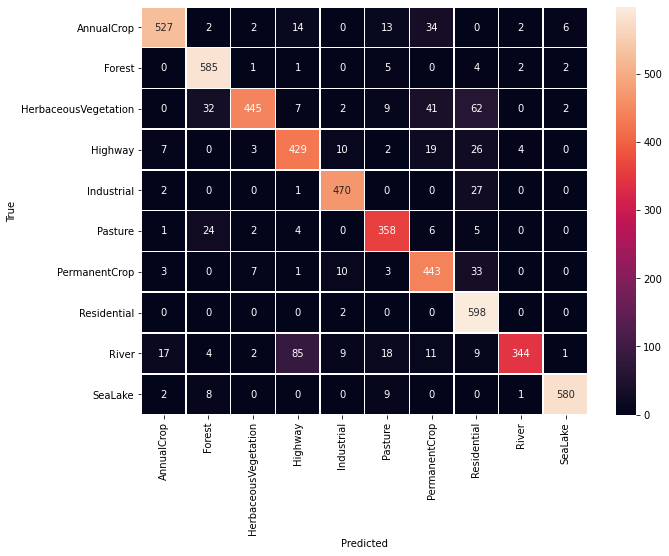

In [ ]:
plt.figure(figsize=[10.0, 7.5])
sns.heatmap(confusion_matrix(y_val, ypred), annot=True, fmt="d", linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(0.5,10), ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], rotation='vertical')
plt.yticks(np.arange(0.5,10), ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], rotation='horizontal')
plt.show()

**Image Segmentation**

(1920, 1241)


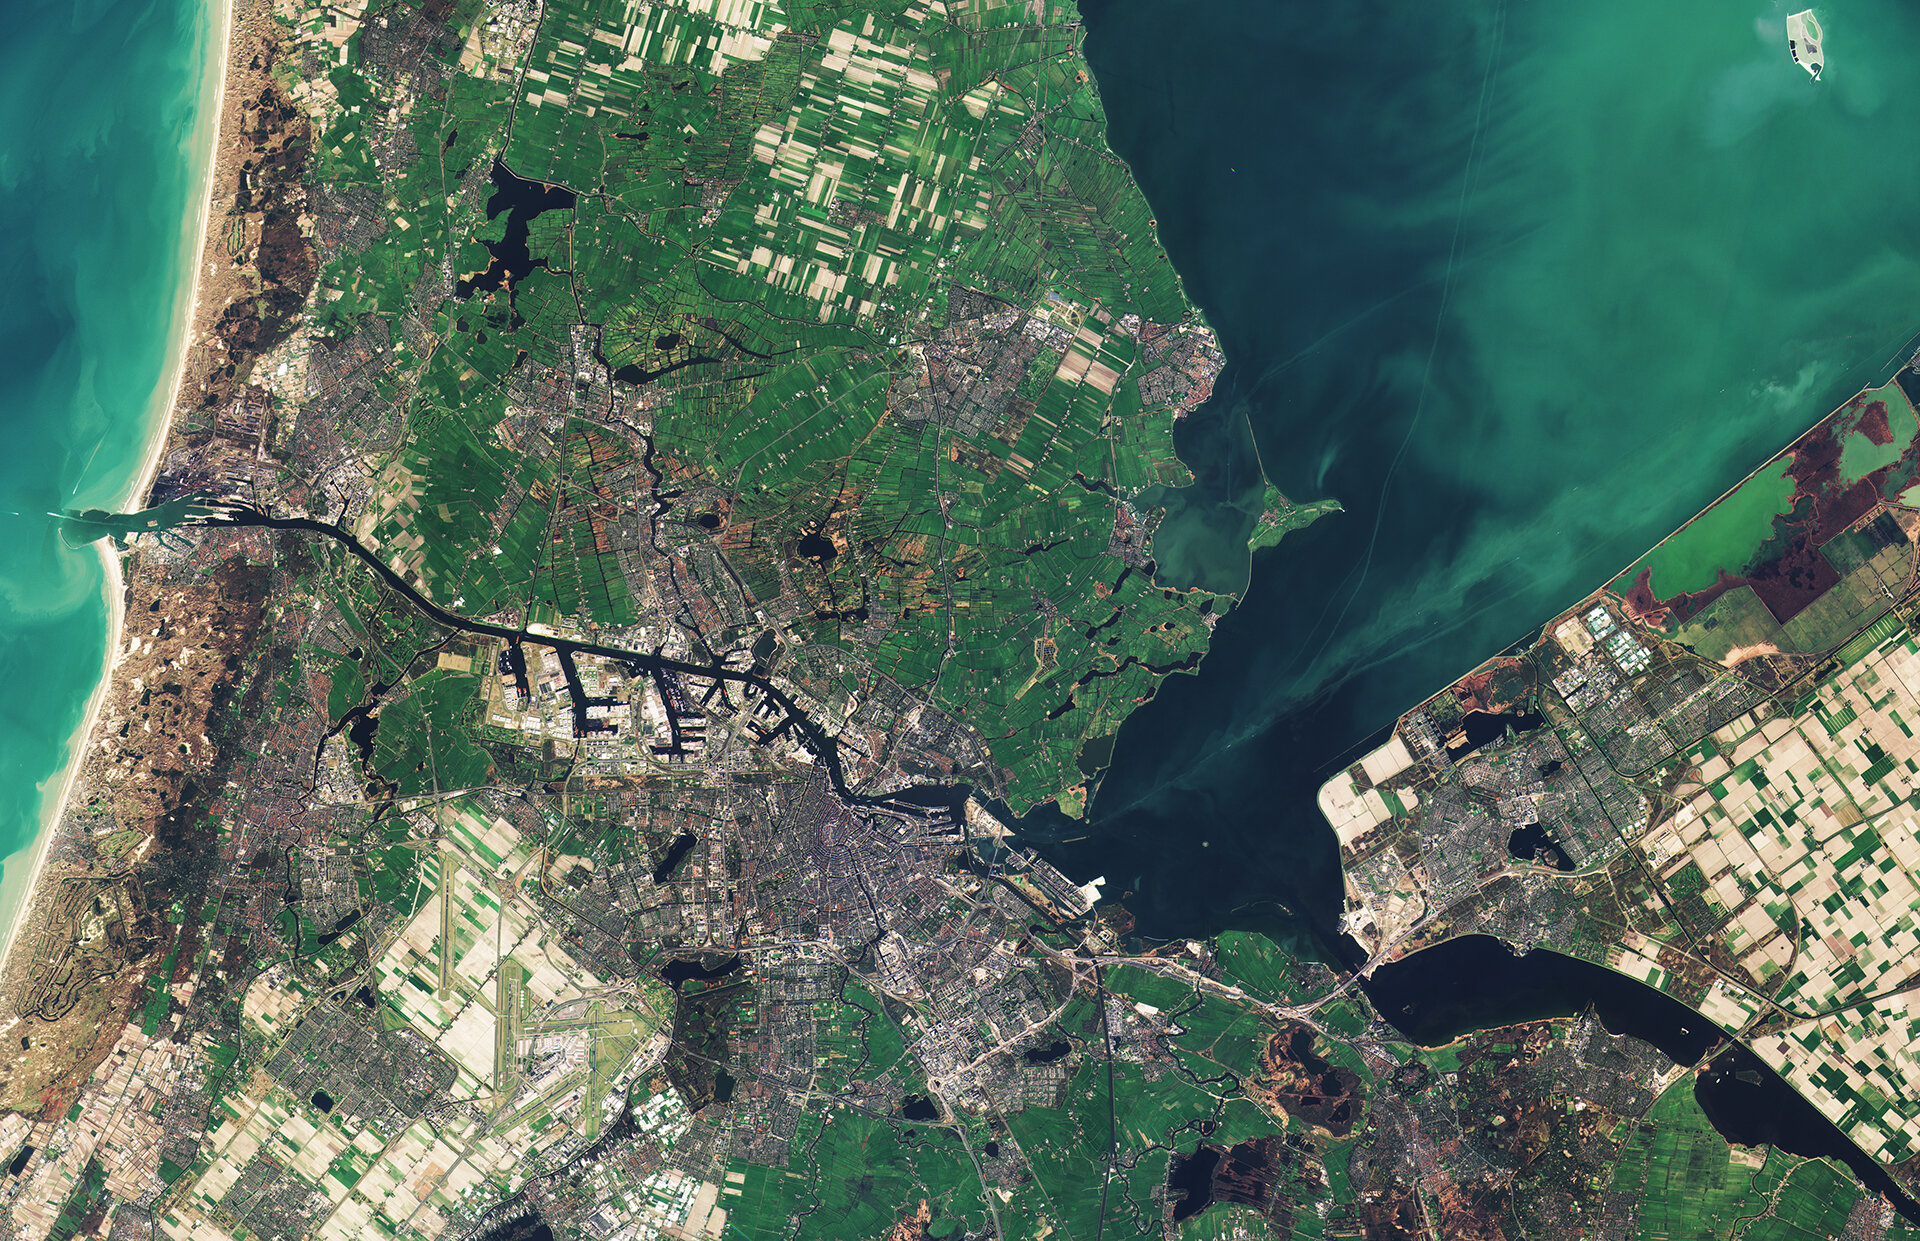

In [ ]:
img = image.load_img('/content/drive/My Drive/Amsterdam.jpg')
print(img.size)
img

In [ ]:
img_array = image.img_to_array(img)
img_array = img_array.astype(np.uint8)

slices = []
for x in range(0, img_array.shape[0], 64):
    for y in range(0, img_array.shape[1], 64):
        box = img_array[x:x+64, y:y+64, :]
        if box.shape == (64, 64, 3):
            slices.append(box)

SeaLake


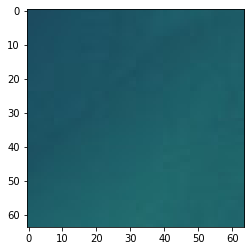

In [ ]:
img_test=slices[0]

img_test_r = img_test.reshape((1,64, 64, 3))
test_result_array = loaded_model.predict(img_test_r)
test_result = test_result_array[0].tolist()

def result_class(classes, results):
  my_dict=dict(zip(classes, results))
  class_key = [k for k,v in my_dict.items() if v==max(my_dict.values())]
  return class_key[0]

print(result_class(val_data.class_indices.keys(), test_result))

plt.imshow(img_test)

In [ ]:
slices = np.array(slices)
result = loaded_model.predict(slices)

result_classes = []
for i in range(len(slices)):
  dict_keys=val_data.class_indices.keys()
  cl_dict=dict(zip(dict_keys, result[i]))
  classkey = [k for k,v in cl_dict.items() if v==max(cl_dict.values())]
  result_classes.append(classkey[0])

slices_list=list(zip(result_classes,slices))


for key, value in slices_list:
  font = cv2.FONT_HERSHEY_SIMPLEX
  if key == 'AnnualCrop':
    value = cv2.rectangle(value,(0,0),(63,63),(255,255,0),3) #COLOR
    cv2.putText(value,'0',(5,15), font, 0.5,(255,255,0),1,cv2.LINE_AA) #NUMBER

  elif key == 'Forest':
    value = cv2.rectangle(value,(0,0),(63,63),(0,255,0),3) #COLOR
    cv2.putText(value,'1',(5,15), font, 0.5,(0,255,0),1,cv2.LINE_AA) #NUMBER

  elif key == 'HerbaceousVegetation':
    value = cv2.rectangle(value,(0,0),(63,63),(255,0,255),3) #COLOR
    cv2.putText(value,'2',(5,15), font, 0.5,(255,0,255),1,cv2.LINE_AA) #NUMBER
  
  elif key == 'Highway':
    value = cv2.rectangle(value,(0,0),(63,63),(0,255,255),3)
    cv2.putText(value,'3',(5,15), font, 0.5,(0,255,255),1,cv2.LINE_AA)

  elif key == 'Industrial':
    value = cv2.rectangle(value,(0,0),(63,63),(255,0,0),3)
    cv2.putText(value,'4',(5,15), font, 0.5,(255,0,0),1,cv2.LINE_AA)

  elif key == 'Pasture':
    value = cv2.rectangle(value,(0,0),(63,63),(0,128,0),3)
    cv2.putText(value,'5',(5,15), font, 0.5,(0,128,0),1,cv2.LINE_AA)  

  elif key == 'PermanentCrop':
    value = cv2.rectangle(value,(0,0),(63,63),(128,0,0),3)
    cv2.putText(value,'6',(5,15), font, 0.5,(128,0,0),1,cv2.LINE_AA) 

  elif key == 'Residential':
    value = cv2.rectangle(value,(0,0),(63,63),(0,0,0),3)
    cv2.putText(value,'7',(5,15), font, 0.5,(0,0,0),1,cv2.LINE_AA)

  elif key == 'River':
    value = cv2.rectangle(value,(0,0),(63,63),(128,0,128),3)
    cv2.putText(value,'8',(5,15), font, 0.5,(128,0,128),1,cv2.LINE_AA) 

  elif key == 'SeaLake':
    value = cv2.rectangle(value,(0,0),(63,63),(128,128,0),3)
    cv2.putText(value,'9',(5,15), font, 0.5,(128,128,0),1,cv2.LINE_AA)

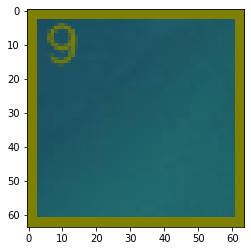

In [ ]:
plt.imshow(slices[0])

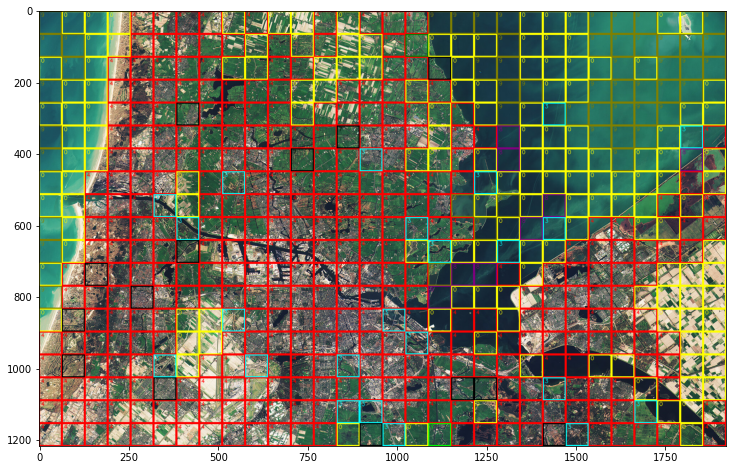

In [ ]:
row_length = int(img.size[0]/64)
columns = int(len(slices)/row_length)

im = []
for i in range(columns):
  row = np.hstack(slices[i*row_length:(i+1)*row_length])
  im.append(row)

rec_img = np.vstack(im)
plt.figure(figsize = (16,8))
plt.imshow(rec_img)
#rec_img.shape

**Class Activation Map (Heatmap)**

In [ ]:
#model=VGG16(weights='imagenet')

503
(1, 64, 64, 3)


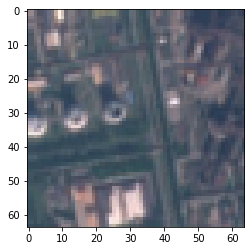

In [400]:
nr=np.random.randint(1,2000)
img_path = f'my_data/2750/Industrial/Industrial_{nr}.jpg'
img = image.load_img(img_path)
img_array = image.img_to_array(img)
img_array=img_array.reshape((1,64,64,3))
print(nr)
print(img_array.shape)
plt.imshow(img)

In [401]:
def result_class(classes, results):
  my_dict=dict(zip(classes, results))
  class_key = [k for k,v in my_dict.items() if v==max(my_dict.values())]
  return class_key[0]

img_array = preprocess_input(img_array)
preds = model_01.predict(img_array)
result_class(val_data.class_indices.keys(), preds[0])

'Industrial'

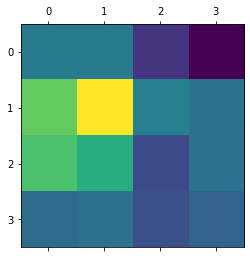

In [402]:
argmax = np.argmax(preds[0])
output = model_01.output[:, argmax]
last_conv_layer = model_01.get_layer('conv2d_31')
from keras import backend as K
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model_01.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_array])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

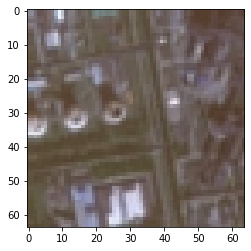

In [403]:
img = cv2.imread(img_path)
plt.imshow(img)

In [404]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img

output = '/output.jpeg'
cv2.imwrite(output, superimposed_img)

True

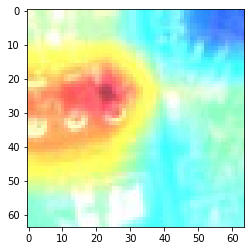

In [405]:
img=mpimg.imread(output)
plt.imshow(img)